## Twitter sentiment Analysis


### Project Overview

In a dynamic digital landscape, understanding public sentiment towards technology giants like Apple and Google is paramount. This project aims to harness the power of Natural Language Processing (NLP) to conduct a comprehensive sentiment analysis of tweets related to their products. By leveraging a dataset containing over 9,000 manually annotated tweets, we seek to create a robust model that discerns sentiments as positive, negative, or neutral. The multifaceted nature of this analysis offers valuable insights for businesses, marketing strategists, and researchers invested in the consumer electronics domain.

### Business Understanding

In the era of social media dominance, the reputation and perception of tech companies can be heavily influenced by user-generated content. Understanding the sentiment expressed on platforms like Twitter provides a unique opportunity to gauge public perception, inform strategic decisions, and enhance customer engagement strategies. By delving into the sentiment surrounding Apple and Google products, businesses can gain actionable insights, refine their marketing approaches, and maintain a pulse on the evolving consumer landscape.

### Objectives:

1. To identify unique words associated with positive, negative, and neutral sentiments in the dataset.

2. Initiate the project with a focused binary classifier to distinguish positive and negative sentiments. Gradually extend the model's capabilities to handle neutral sentiments, ensuring a robust multiclass classification system(Proof of Concept).

3. Develop a sophisticated NLP model capable of accurately classifying tweet sentiments as positive, negative, or neutral, providing nuanced insights into the public's opinions(Sentiment Analysis). The criterion for building a "sophisticated model" is that the model should have an acceptable accuracy of 80% and above. Also it should be able to differentiate between the 3 target classes.



Importing the necessary libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re


from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet, words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

# Download the WordNet and punkt resources if not already downloaded
nltk.download('wordnet')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))
english_words = set(words.words())

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brandon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Functions used in the project:

In [2]:
def load_csv_to_dataframe(file_path):
    """
    Load a CSV file into a pandas DataFrame.

    Parameters:
    - file_path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    df = pd.read_csv(file_path, encoding='latin-1')
    return df

def dataframe_preview(dataframe):
    #To get the shape of the dataframe
    print("The shape of the dataframe:")
    print(dataframe.shape)
    print('\n')
    #Describe the dataframe
    print("Describing the dataframe:")
    print(dataframe.describe())
    print('\n')
    #checking the columns in the dataset
    print("Columns in the dataset:")
    print(dataframe.columns)
    print('\n')
    #To get the info of the dataframe
    print("The data in the dataframe:")
    print(dataframe.info())
    print('\n')

def clean_tweet_text(text):
    try:
        cleaned_text = re.sub(r'@\w+', '', str(text))
        cleaned_text = re.sub(r'http\S+|www\S+|[^a-zA-Z\s]', '', cleaned_text)
        cleaned_text = cleaned_text.encode('ascii', 'ignore').decode()
        return cleaned_text.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

def extract_hashtag_words(text):
    try:
        hashtags = re.findall(r'#(\w+)', text)
        h = ''
        for hashtag in hashtags:
            h += str(hashtag) + ','
        return h.lower()
    except Exception as e:
        print(f"Error processing text: {text}. Error: {e}")
        return text

# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(tag))
                         for token, tag in nltk.pos_tag(tokens)]
    return ' '.join(lemmatized_tokens)

# Function to map POS tags from Penn Treebank to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default to NOUN if not recognized


## Data understanding

### Loading data
In this section, we will upload data and conduct surface analysis whereby we will check  the shape,check for null values

In [3]:
file_path = 'tweet_product_company.csv'

# Loading the CSV file into a pandas DataFrame
df = load_csv_to_dataframe(file_path)

# Display the DataFrame
print(df)

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

     emotion_in_tweet_is_directed_at  \
0                             iPhone   
1                 iPad or iPhone App   
2                               iPad   
3                 iPad or iPhone App   
4                             Google   
...                              ...   
9088       

We get to see that our dataset contains 9093 rows and 3 columns which are 
1. tweet_text
2. emotion_in_tweet_is_directed_at: The product/service the sentiment was directed towards.
3. is_there_an_emotion_directed_at_a_brand_or_product

In [4]:
#Call function to preview the data
dataframe_preview(df)

The shape of the dataframe:
(9093, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

## Data cleaning

We will now proceed to cleaning the data.This involves removing duplicates and droping null values which were observed above. We will also try to extract all usefull information from the tweet removing unneccessary characters like usernames, links and special characters.

In [5]:
#Check duplicate examples.
duplicate_rows = df[df.duplicated(subset='tweet_text', keep=False)]
print("Duplicate Rows based on 'tweet_text' column:")
print(duplicate_rows)

Duplicate Rows based on 'tweet_text' column:
                                             tweet_text  \
7     #SXSW is just starting, #CTIA is around the co...   
9     Counting down the days to #sxsw plus strong Ca...   
17    I just noticed DST is coming this weekend. How...   
20    Need to buy an iPad2 while I'm in Austin at #s...   
21    Oh. My. God. The #SXSW app for iPad is pure, u...   
24    Really enjoying the changes in Gowalla 3.0 for...   
466      Before It Even Begins, Apple Wins #SXSW {link}   
468      Before It Even Begins, Apple Wins #SXSW {link}   
774   Google to Launch Major New Social Network Call...   
776   Google to Launch Major New Social Network Call...   
2230  Marissa Mayer: Google Will Connect the Digital...   
2232  Marissa Mayer: Google Will Connect the Digital...   
2559  Counting down the days to #sxsw plus strong Ca...   
3811           Win free ipad 2 from webdoc.com #sxsw RT   
3812           Win free iPad 2 from webdoc.com #sxsw RT   
3813       

In [6]:
# Dropping duplicate entries in the tweet_text column
df.drop_duplicates(subset='tweet_text', keep='first', inplace=True)


In [7]:
# Check the dataframe
dataframe_preview(df)

The shape of the dataframe:
(9066, 3)


Describing the dataframe:
                                               tweet_text  \
count                                                9065   
unique                                               9065   
top     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
freq                                                    1   

       emotion_in_tweet_is_directed_at  \
count                             3280   
unique                               9   
top                               iPad   
freq                               943   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9066  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5373  


Columns in the dataset:
Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directe

In [8]:
# checking for total null values for each column in the dataset
missing_values = df.isnull().sum()

print(missing_values)

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5786
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


In [9]:
# Drop the null values
df = df.dropna(subset=['tweet_text'])

In [10]:
# Check if all missing values are dropped.
missing_values = df.isnull().sum()
print(missing_values)

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5785
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


This code uses regular expressions to replace user mentions, remove links, and non-alphanumeric characters. If you want to retain hashtags, you can uncomment the 'hashtags' line. Adjustments can be made based on specific cleaning requirements.

In [11]:
# Assuming 'df' is the DataFrame containing the dataset
df['clean_text'] = df['tweet_text'].apply(clean_tweet_text)
df['hashtags'] = df['tweet_text'].apply(extract_hashtag_words)

df['clean_text'][0]


' i have a g iphone after  hrs tweeting at riseaustin it was dead  i need to upgrade plugin stations at sxsw'

In [12]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,i have a g iphone after hrs tweeting at rise...,"rise_austin,sxsw,"
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know about awesome ipadiphone app that youl...,"sxsw,"
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,can not wait for ipad also they should sale ...,"ipad,sxsw,"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,i hope this years festival isnt as crashy as ...,"sxsw,"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff on fri sxsw marissa mayer google ...,"sxsw,"


### Exploratory Data Analysis

We will not get indepth with our data so as to understand it more. We will look at the available columns as well as do some feature engineering.

In [13]:
# Explore 'tweet_text' column
tweet_text_distribution = df['tweet_text'].value_counts()

# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Explore 'is_there_an_emotion_directed_at_a_brand_or_product' column
emotion_directed_at_distribution = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Display the distributions
print("Distribution of 'tweet_text' values:")
print(tweet_text_distribution)

print("\nDistribution of 'emotion_in_tweet_is_directed_at' values:")
print(emotion_distribution)

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)

Distribution of 'tweet_text' values:
tweet_text
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.         1
RT @mention I think #Google lost their way by caring too much about their business (instead of their users) Tim O'Reilly #sxsw #pnid    1
RT @mention I just fell asleep for 2 hours with my eyes open, staring into the #SXSW stream on my iPad 2. {link}                        1
RT @mention I just found BBQ sauce on my iPad - tech and Texas really do come together here!  #SXSW                                     1
RT @mention I know it's #SXSW because my iPhone has started lying to me about its signal strength.                                      1
                                                                                                                                       ..
Apple Offers Up Free iTunes Sampler Ahead of #SXSW to feature new artists {link} via @mention #music                        

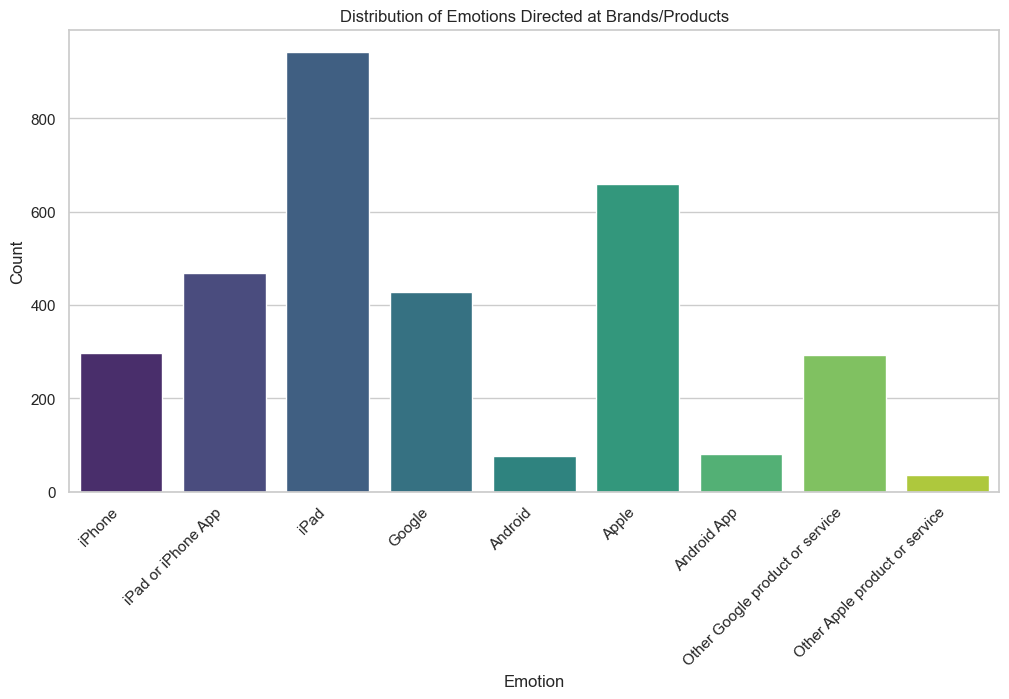

In [14]:
# Explore 'emotion_in_tweet_is_directed_at' column
emotion_distribution = df['emotion_in_tweet_is_directed_at'].value_counts()

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a colorful count plot
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, palette="viridis")

# Add labels and title
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


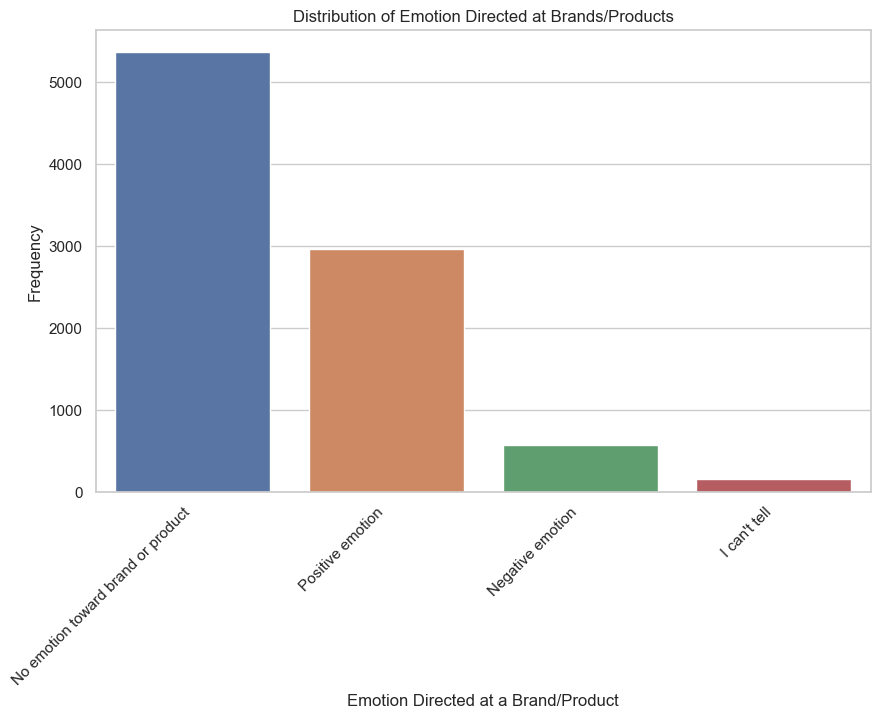

In [15]:
# Bar chart for 'is_there_an_emotion_directed_at_a_brand_or_product'
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_directed_at_distribution.index, y=emotion_directed_at_distribution.values, palette='deep')
plt.title('Distribution of Emotion Directed at Brands/Products')
plt.xlabel('Emotion Directed at a Brand/Product')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [16]:

print("\nDistribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:")
print(emotion_directed_at_distribution)


Distribution of 'is_there_an_emotion_directed_at_a_brand_or_product' values:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64


In [17]:
# Create the Neutral Emotion Target Class.
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].replace({
    "I can't tell": 'Neutral emotion',
    'No emotion toward brand or product': 'Neutral emotion'
})

# Verify the changes
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: count, dtype: int64


In [18]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: count, dtype: int64

In [19]:
# Import necessary libraries
import pandas as pd

# Assuming df is your DataFrame
df['brand'] = df['emotion_in_tweet_is_directed_at'].map({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
})

# Verify the changes
print(df['brand'].value_counts())


brand
Apple     2402
Google     585
Name: count, dtype: int64


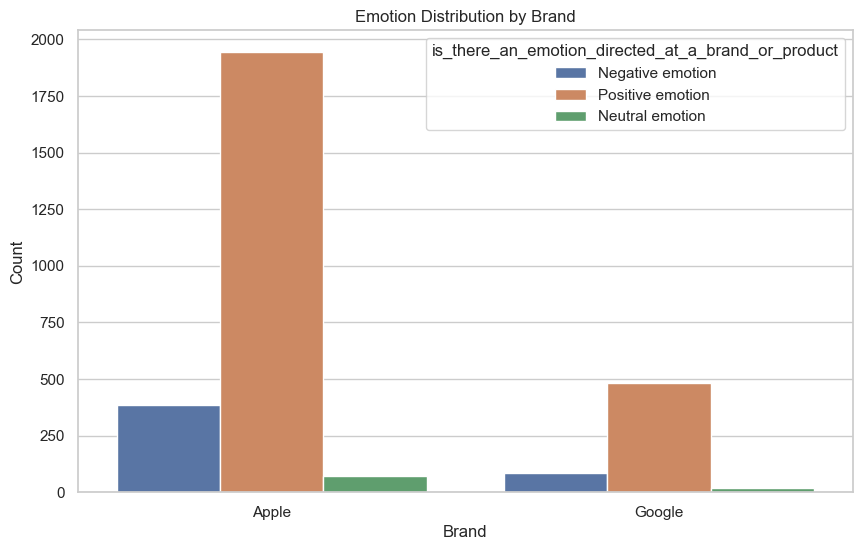

In [20]:

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='brand', hue='is_there_an_emotion_directed_at_a_brand_or_product', data=df)

# Add labels and title
plt.xlabel('Brand')
plt.ylabel('Count')
plt.title('Emotion Distribution by Brand')

# Show the plot
plt.show()


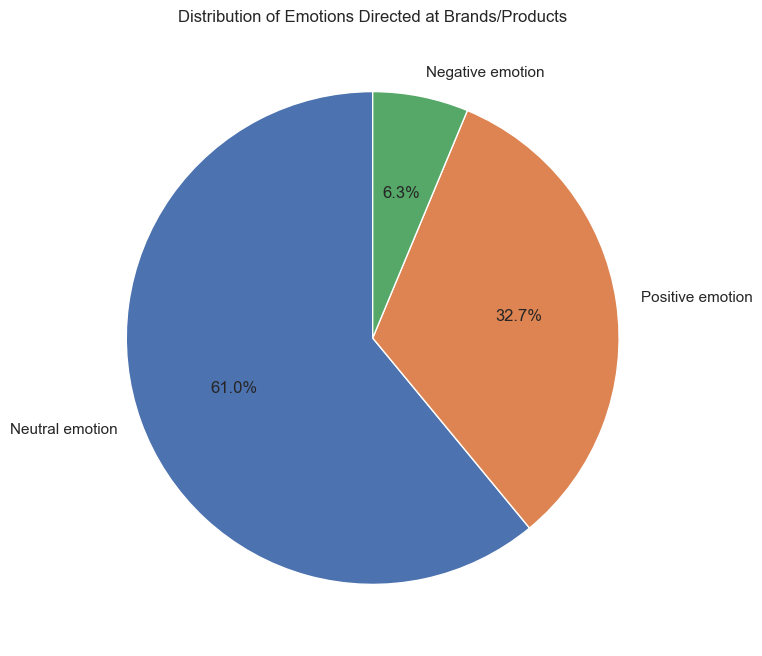

In [21]:
# Count the values of 'is_there_an_emotion_directed_at_a_brand_or_product'
emotion_distribution = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
# Choose a different color palette
colors = sns.color_palette("deep")[0:len(emotion_distribution)]

# Plot a beautiful pie chart with the new color palette
plt.figure(figsize=(8, 8))
plt.pie(emotion_distribution, labels=emotion_distribution.index, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Distribution of Emotions Directed at Brands/Products')
plt.show()

Analysing the most common hashtags.

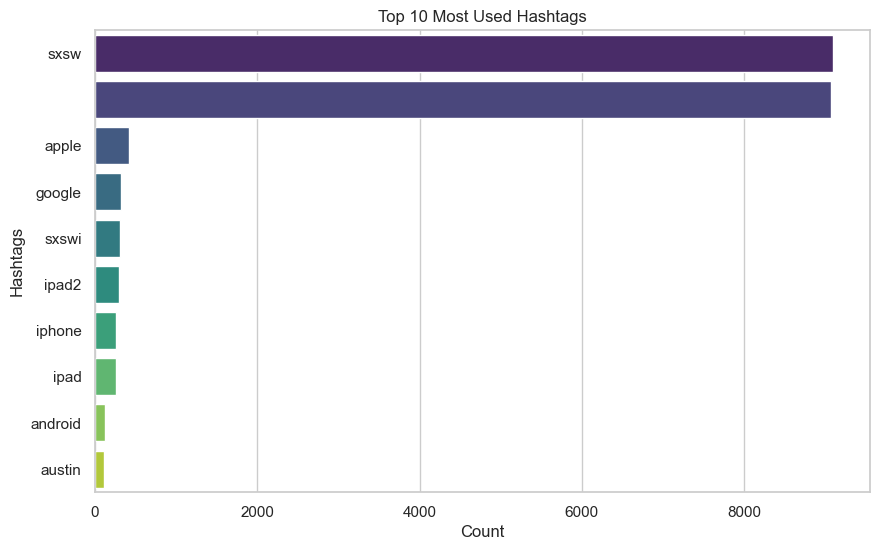

In [22]:
# Hashtag DataFrame
hashtags_df = pd.DataFrame()

# Split the hashtags into a list
hashtags_df['hashtags_list'] = df['hashtags'].str.split(',')

# Flatten the list of hashtags
flat_hashtags_list = [item for sublist in hashtags_df['hashtags_list'] for item in sublist]

# Create a Series to count the occurrences of each hashtag
hashtags_counts = pd.Series(flat_hashtags_list).value_counts()

# Select the top 10 hashtags
top_10_hashtags = hashtags_counts.head(10)

# Plot the word count for the top 10 hashtags
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_hashtags.values, y=top_10_hashtags.index, palette="viridis")
plt.title('Top 10 Most Used Hashtags')
plt.xlabel('Count')
plt.ylabel('Hashtags')
plt.show()


Investigating the most commonly used words within the tweets that display the Positive, Negative and Neutral Emotions.

In [23]:


# Function to tokenize and remove stopwords from a text
def process_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words and word.lower() in english_words]
    return tokens


In [24]:
# Separate the data into Positive, Negative, and Neutral subsets
positive_tweets = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['clean_text']
negative_tweets = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['clean_text']
neutral_tweets = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Neutral emotion']['clean_text']

# Process the text for each category
positive_tokens = positive_tweets.apply(process_text)
negative_tokens = negative_tweets.apply(process_text)
neutral_tokens = neutral_tweets.apply(process_text)

# Convert token lists to sets for positive, negative, and neutral categories
unique_positive_tokens = set([token for sublist in positive_tokens for token in sublist])
unique_negative_tokens = set([token for sublist in negative_tokens for token in sublist])
unique_neutral_tokens = set([token for sublist in neutral_tokens for token in sublist])

# Exclude words that appear in more than one category
unique_positive_words = unique_positive_tokens - (unique_negative_tokens | unique_neutral_tokens)
unique_negative_words = unique_negative_tokens - (unique_positive_tokens | unique_neutral_tokens)
unique_neutral_words = unique_neutral_tokens - (unique_positive_tokens | unique_negative_tokens)

# Display the unique words for each category
print("\nUnique Positive Words:")
print(list(unique_positive_words)[:20])

print("\nUnique Negative Words:")
print(list(unique_negative_words)[:20])

print("\nUnique Neutral Words:")
print(list(unique_neutral_words)[:20])



Unique Positive Words:
['vacation', 'dairy', 'peddle', 'casually', 'writer', 'counting', 'bowl', 'fandango', 'trophy', 'epicenter', 'craps', 'wasting', 'stunning', 'dynamic', 'script', 'stillman', 'tractor', 'tether', 'appreciation', 'fabulous']

Unique Negative Words:
['express', 'predictability', 'flaw', 'abandoned', 'rip', 'insidious', 'fragmentation', 'severe', 'hubby', 'abacus', 'trashy', 'darn', 'pragmatic', 'unstable', 'restore', 'realistic', 'comedy', 'deficit', 'giggling', 'brick']

Unique Neutral Words:
['ate', 'farmy', 'massage', 'quote', 'dried', 'compliment', 'viral', 'tribute', 'tattoo', 'peep', 'eventful', 'bridge', 'dinosaur', 'originally', 'female', 'splash', 'ne', 'situation', 'smoked', 'condescending']


In [25]:
# Flatten the list of tokens for each category
positive_tokens_flat = [token for sublist in positive_tokens for token in sublist]
negative_tokens_flat = [token for sublist in negative_tokens for token in sublist]
neutral_tokens_flat = [token for sublist in neutral_tokens for token in sublist]

# Calculate word frequencies for each category
fdist_positive = FreqDist(positive_tokens_flat)
fdist_negative = FreqDist(negative_tokens_flat)
fdist_neutral = FreqDist(neutral_tokens_flat)

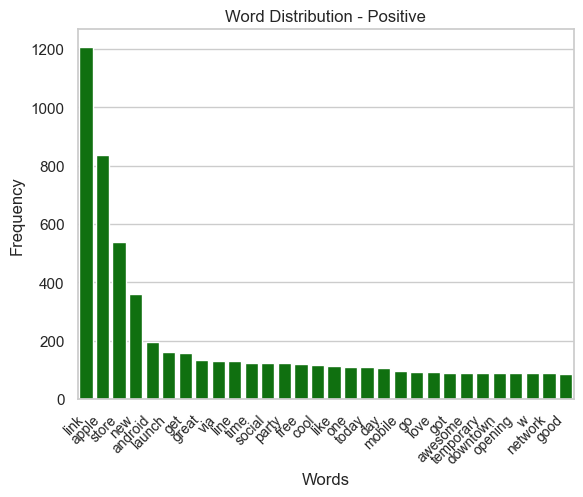

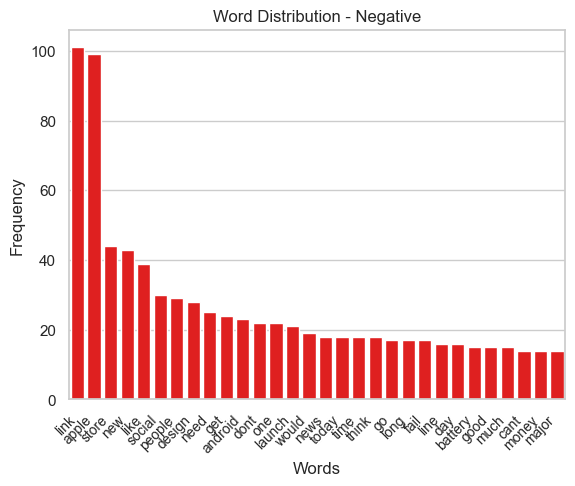

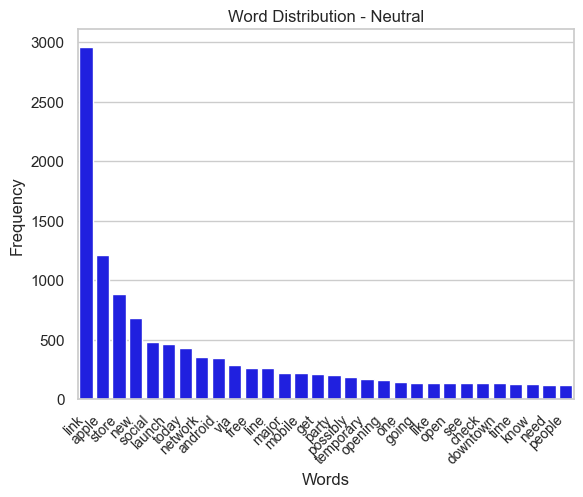

In [26]:
# Function to plot word distribution for each category with seaborn
def plot_word_distribution(fdist, label, color):
    sns.barplot(x=[word[0] for word in fdist.most_common(30)],
                y=[freq[1] for freq in fdist.most_common(30)],
                color=color)
    plt.title(f"Word Distribution - {label}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.show()

# Set the style for the plot
sns.set(style="whitegrid")
sns.set_palette("husl")  # Set a color palette

# Plot word distribution for each category
plot_word_distribution(fdist_positive, "Positive", 'green')
plot_word_distribution(fdist_negative, "Negative", 'red')
plot_word_distribution(fdist_neutral, "Neutral", 'blue')

### Data Preprocessing
Most of the crucial steps like removing links and hashtags as well as special characters was performed in the data cleaning process.

However although the text we have remained with is "cleaned". Some preprocessing can be added to enable our model to become better.

In this section we will attempt to remove stop words and non English words.

In [27]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5528
Positive emotion    2968
Negative emotion     569
Name: count, dtype: int64

In [28]:

# Create a LabelEncoder object
enc = LabelEncoder()

# Fit and transform the specified column in the DataFrame
df['is_there_an_emotion_directed_at_a_brand_or_product'] = enc.fit_transform(df['is_there_an_emotion_directed_at_a_brand_or_product'])
df['brand'] = enc.fit_transform(df['brand'])
df['emotion_in_tweet_is_directed_at'] = enc.fit_transform(df['emotion_in_tweet_is_directed_at'])

print(df['brand'].value_counts())
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

brand
2    6078
0    2402
1     585
Name: count, dtype: int64
is_there_an_emotion_directed_at_a_brand_or_product
1    5528
2    2968
0     569
Name: count, dtype: int64


In [29]:
# Load the stop words
stop_words = set(stopwords.words('english'))

# Assuming df is your DataFrame and 'clean_text' is the column containing the tweets
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,8,0,g iphone hrs tweeting riseaustin dead need upg...,"rise_austin,sxsw,",0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,7,2,know awesome ipadiphone app youll likely appre...,"sxsw,",0
2,@swonderlin Can not wait for #iPad 2 also. The...,6,2,wait ipad also sale sxsw,"ipad,sxsw,",0
3,@sxsw I hope this year's festival isn't as cra...,7,0,hope years festival isnt crashy years iphone a...,"sxsw,",0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,3,2,great stuff fri sxsw marissa mayer google tim ...,"sxsw,",1


In [30]:
# Load the stop words and English words set
stop_words = set(stopwords.words('english'))
english_words = set(words.words())

# Assuming df is your DataFrame and 'clean_text' is the column containing the tweets
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words and word.lower() in english_words]))

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,8,0,g dead need upgrade,"rise_austin,sxsw,",0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,7,2,know awesome likely appreciate design also the...,"sxsw,",0
2,@swonderlin Can not wait for #iPad 2 also. The...,6,2,wait also sale,"ipad,sxsw,",0
3,@sxsw I hope this year's festival isn't as cra...,7,0,hope festival,"sxsw,",0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,3,2,great stuff tech,"sxsw,",1


In [31]:
#Lematize the words
df['clean_text'] = df['clean_text'].apply(lemmatize_sentence)

# Remove one-word sentences
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

# View the cleaned column
df['clean_text'].head()

0                                    dead need upgrade
1    know awesome likely appreciate design also the...
2                                       wait also sale
3                                        hope festival
4                                     great stuff tech
Name: clean_text, dtype: object

### Modelling.

#### Base Model

For starters we aim to create a binary classifier that can predict if a tweet is positive or negative. To achieve this. We create a new dataframe that only has positive and negative in the target class.

In [32]:
# 0 is positive and 2 is negative
binary_df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin([0, 2])].copy()

# Map 0 to negative and 1 to positive for easier comprehension
binary_df['is_there_an_emotion_directed_at_a_brand_or_product'] = binary_df['is_there_an_emotion_directed_at_a_brand_or_product'].map({0: 1, 2: 0})

# Remove the initial tweet column
binary_df.drop('tweet_text', axis=1)

,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_text,hashtags,brand
0,8,1,dead need upgrade,"rise_austin,sxsw,",0
1,7,0,know awesome likely appreciate design also the...,"sxsw,",0
2,6,0,wait also sale,"ipad,sxsw,",0
3,7,1,hope festival,"sxsw,",0
4,3,0,great stuff tech,"sxsw,",1
...,...,...,...,...,...
9077,8,0,guy convince switch back great coverage princess,"sxsw,princess,",0
9079,6,0,like nice,"sxsw,",0
9080,5,1,run essentially ready,"sxsw,diller,",2
9085,7,0,always use camera image stabilizer mode cam fe...,"sxsw,sxswi,",0


In [33]:
#Split the dataset into train and test
X = binary_df.drop(['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'hashtags'], axis=1)
y = binary_df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train['clean_text'])
X_test_vec = vectorizer.transform(X_test['clean_text'])

In [35]:
from sklearn.naive_bayes import BernoulliNB

classifier = BernoulliNB()

In [36]:
classifier.fit(X_train_vec, y_train)

BernoulliNB()

In [37]:
predictions = classifier.predict(X_test_vec)

In [38]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


Accuracy: 0.867231638418079
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92       595
           1       0.65      0.36      0.47       113

    accuracy                           0.87       708
   macro avg       0.77      0.66      0.70       708
weighted avg       0.85      0.87      0.85       708



The classification model achieved an overall accuracy of 86.72%, signifying its ability to correctly predict the class labels. Class-specific metrics reveal that for class 0, representing the majority class, the model exhibited high precision (89%), recall (96%), and F1-score (92%), indicating robust performance. However, for class 1, the minority class, the model showed lower precision (65%) and recall (36%), resulting in a lower F1-score (47%). The weighted average F1-score, considering class imbalance, was 0.85, reflecting a generally favorable model performance across both classes. Nevertheless, attention should be paid to the lower performance on the minority class, where the model struggles to correctly identify instances, as evidenced by the lower recall and precision values. Further optimization, particularly focusing on class imbalance, may enhance the model's effectiveness in capturing both class patterns.

#### Multiclass Model

Though the baseline model is okay. Improvements can be made. As an example creating a multiclass model that can incorporate the neutral class as well. This might yield better results.

In [39]:
# Separate features and target variable and dropping irrelevant columns
X = df.drop(['tweet_text', 'clean_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'hashtags'], axis=1)
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Initialize a logistic regression model
logreg_model = LogisticRegression()

# Fit the model using cross-validation
cross_val_scores = cross_val_score(logreg_model, X_train, y_train, cv=5)  # You can adjust the number of folds (cv) as needed

# Print the cross-validation scores
print("Cross-validation scores:", cross_val_scores)

# Fit the model on the training data
logreg_model.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = logreg_model.score(X_test, y_test)
print("Test set accuracy:", accuracy)


Cross-validation scores: [0.89248794 0.89524466 0.89034483 0.89310345 0.89103448]
Test set accuracy: 0.8924434638720353


The cross-validation scores, [0.89248794, 0.89524466, 0.89034483, 0.89310345, 0.89103448], represent the accuracy achieved by a model across different folds during cross-validation, indicating its performance consistency on varying subsets of the dataset. These values consistently range from approximately 89.0% to 89.5%. The test set accuracy of 0.8924434638720353, obtained on a separate, unseen dataset, aligns closely with the cross-validation scores, reinforcing the model's ability to generalize well to new data. This coherence between cross-validation and test set performance suggests that the model maintains stability and robustness, providing confidence in its overall accuracy and reliability on diverse samples from the dataset.

Third Iterantion. An advanced model, here we opted for a Random Forest Classifier.

In [41]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming you have already loaded your dataframe 'df'

# Separate features and target variable and dropping irrelevant columns
X = df.drop(['tweet_text', 'clean_text', 'is_there_an_emotion_directed_at_a_brand_or_product', 'hashtags'], axis=1)
y = df['is_there_an_emotion_directed_at_a_brand_or_product']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
random_forest_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.8924434638720353

Confusion Matrix:
[[   0    5  114]
 [   0 1092   20]
 [   0   56  526]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.95      0.98      0.96      1112
           2       0.80      0.90      0.85       582

    accuracy                           0.89      1813
   macro avg       0.58      0.63      0.60      1813
weighted avg       0.84      0.89      0.86      1813



c:\Users\Brandon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brandon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brandon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

The Random Forest did not improve significantly. We then tried to implement a grid search to evaluate if there are better hyperparameters than the default one for the Random Forest.

In [42]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest model
random_forest_model = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, 
                           scoring='accuracy', cv=3, n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print("Best Hyperparameters:", best_params)
print(f"\nBest Model Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Best Model Accuracy: 0.8924434638720353

Confusion Matrix:
[[   0    5  114]
 [   0 1092   20]
 [   0   56  526]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       119
           1       0.95      0.98      0.96      1112
           2       0.80      0.90      0.85       582

    accuracy                           0.89      1813
   macro avg       0.58      0.63      0.60      1813
weighted avg       0.84      0.89      0.86      1813



c:\Users\Brandon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brandon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Brandon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

The results indicate that the best-performing model was trained with hyperparameters {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}. This model achieved an accuracy of 89.24%. The confusion matrix reveals that the model struggled particularly with class 0, as it failed to correctly predict any instances for this class, showing precision, recall, and F1-score values of 0.00. However, for class 1, the model performed exceptionally well with high precision (0.95) and recall (0.98), resulting in a high F1-score of 0.96. Class 2 also demonstrated good performance, with a precision of 0.80, recall of 0.90, and an F1-score of 0.85. The overall classification report underscores the model's effectiveness, especially for the majority class 1, while indicating room for improvement in predicting class 0 instances. The macro-average and weighted-average metrics provide a balanced evaluation, suggesting a reasonable compromise between overall and class-specific performance.

### Conclusion


The Random Forest classification model demonstrates strong overall performance with an accuracy score of 89.2%. Classes 1 and 2 exhibit high precision, recall, and F1-score values, indicating the model's proficiency in correctly classifying instances for these categories. However, for class 0, the model shows lower precision, recall, and F1-score, highlighting challenges in accurately identifying instances of this class. Despite this, the model's weighted average metrics suggest that it performs well when accounting for class sizes. Further investigation into the specific issues impacting class 0 predictions is warranted.


### Next Steps

To address the lower performance in class 'Negative', several next steps can be taken.

1. Additional data collection for class 'Negative' may be beneficial to improve the model's ability to generalize for this category. Hyperparameter tuning and feature engineering could be explored to enhance the model's discriminatory power. 

2. Considering the imbalanced class distribution, techniques like resampling, adjusting class weights during training may help improve overall model performance or using a technique as SMOTE. 

3. Continuous monitoring and validation on new data are essential, and the model should be iteratively refined to ensure its effectiveness in real-world applications.

4. A request to X (fomally known as Twitter) has to be made to access the API. Based on their communication, this process can take upto 5 business days or longer depending on the volume of applications. The API can then be used in conjunction with our model in order to fetch new tweet data and run the model.